In [1]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm 
import numpy as np
from skimage.transform import resize
from numpy.fft import fftn, fftshift

import matplotlib.pyplot as plt
import matplotlib

import os

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
plt.style.use('seaborn-white')
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20
plt.viridis()

<Figure size 432x288 with 0 Axes>

In [3]:
def plot3(data,titles):
    if(len(titles)<3):
        titles=["Plot1", "Plot2", "Plot3"]
    fig,ax = plt.subplots(1,3, figsize=(20,12))
    im=ax[0].imshow(data[0])
    ax[0].set_title(titles[0])
    ax[0].axis('off')
    plt.colorbar(im,ax=ax[0], fraction=0.046, pad=0.04)
    im=ax[1].imshow(data[1])
    ax[1].set_title(titles[1])
    ax[1].axis('off')
    plt.colorbar(im,ax=ax[1], fraction=0.046, pad=0.04)
    im=ax[2].imshow(data[2])
    ax[2].set_title(titles[2])
    ax[2].axis('off')
    plt.colorbar(im,ax=ax[2], fraction=0.046, pad=0.04)

In [4]:
EPOCHS = 60
NGPUS = torch.cuda.device_count()
BATCH_SIZE = NGPUS * 64
LR = NGPUS * 1e-3
print("GPUs:", NGPUS, "Batch size:", BATCH_SIZE, "Learning rate:", LR)

GPUs: 1 Batch size: 64 Learning rate: 0.001


In [5]:
H,W = 64,64
NLINES = 100 #How many lines of data to use for training?
NLTEST = 60 #How many lines for the test set?

N_VALID = 805 #How much to reserve for validation

In [6]:
path = os.getcwd()

MODEL_SAVE_PATH = path +'/trained_model/'
if (not os.path.isdir(MODEL_SAVE_PATH)):
    os.mkdir(MODEL_SAVE_PATH)

In [7]:
data_diffr = np.load(path+'/../data/20191008_39_diff.npz')['arr_0']
real_space = np.load(path+'/../data/20191008_39_amp_pha_10nm_full.npy')
amp = np.abs(real_space)
ph = np.angle(real_space)
amp.shape

(161, 161, 64, 64)

In [8]:
print(data_diffr.shape)
#plt.matshow(np.log10(data_diffr[0,0]))

data_diffr_red = np.zeros((data_diffr.shape[0],data_diffr.shape[1],64,64), float)
for i in tqdm(range(data_diffr.shape[0])):
    for j in range(data_diffr.shape[1]):
        data_diffr_red[i,j] = resize(data_diffr[i,j,32:-32,32:-32],(64,64),preserve_range=True, anti_aliasing=True)
        data_diffr_red[i,j] = np.where(data_diffr_red[i,j]<3,0,data_diffr_red[i,j])

  1%|          | 1/161 [00:00<00:24,  6.57it/s]

(161, 161, 256, 256)


100%|██████████| 161/161 [00:23<00:00,  6.75it/s]


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


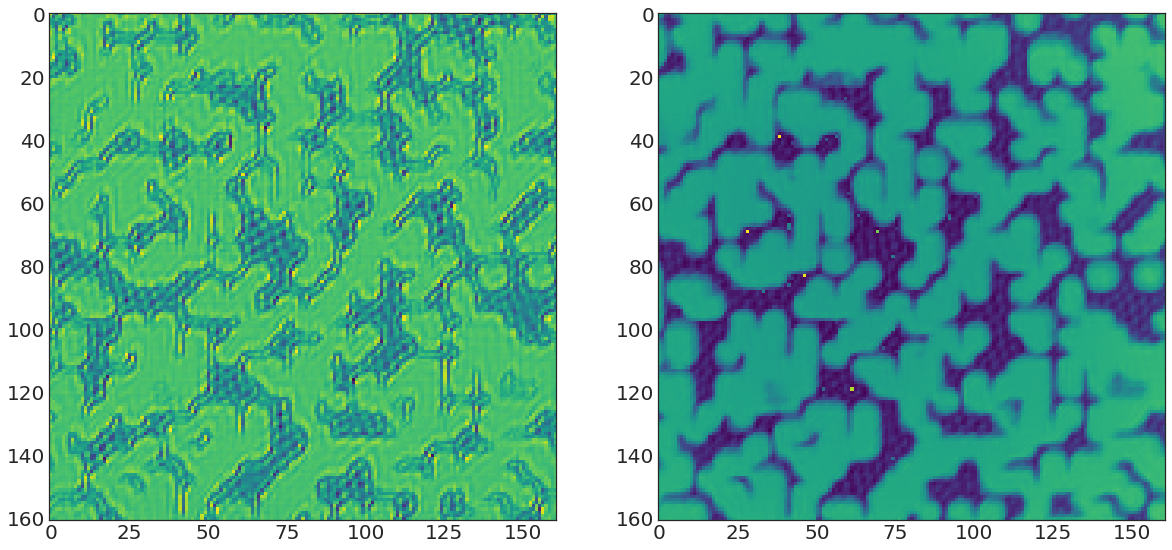

In [9]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(amp[:,:,32,32])
ax[1].imshow(ph[:,:,32,32])

In [10]:
tst_strt = amp.shape[0]-NLTEST #Where to index from
print(tst_strt)

X_train = data_diffr_red[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
X_test = data_diffr_red[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_train = amp[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_test = amp[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_phi_train = ph[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_phi_test = ph[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]

ntrain = X_train.shape[0]*X_train.shape[1]
ntest = X_test.shape[0]*X_test.shape[1]

print(X_train.shape, X_test.shape)

X_train, Y_I_train, Y_phi_train = shuffle(X_train, Y_I_train, Y_phi_train, random_state=0)

101
(16100, 1, 64, 64) (3600, 1, 64, 64)


In [11]:
#Training data
X_train_tensor = torch.Tensor(X_train) 
Y_I_train_tensor = torch.Tensor(Y_I_train) 
Y_phi_train_tensor = torch.Tensor(Y_phi_train)

#Test data
X_test_tensor = torch.Tensor(X_test) 
Y_I_test_tensor = torch.Tensor(Y_I_test) 
Y_phi_test_tensor = torch.Tensor(Y_phi_test)

print(Y_phi_train.max(), Y_phi_train.min())

print(X_train_tensor.shape, Y_I_train_tensor.shape, Y_phi_train_tensor.shape)

train_data = TensorDataset(X_train_tensor,Y_I_train_tensor,Y_phi_train_tensor)
test_data = TensorDataset(X_test_tensor)

3.1268637 -1.564053
torch.Size([16100, 1, 64, 64]) torch.Size([16100, 1, 64, 64]) torch.Size([16100, 1, 64, 64])


In [12]:
N_TRAIN = X_train_tensor.shape[0]
train_data2, valid_data = torch.utils.data.random_split(train_data,[N_TRAIN-N_VALID,N_VALID])
print(len(train_data2),len(valid_data),len(test_data))

15295 805 3600


In [13]:
#download and load training data
trainloader = DataLoader(train_data2, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

validloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

#same for test
#download and load training data
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [14]:
nconv = 32


class recon_model(nn.Module):

    def __init__(self):
        super(recon_model, self).__init__()


        self.encoder = nn.Sequential( # Appears sequential has similar functionality as TF avoiding need for separate model definition and activ
          nn.Conv2d(in_channels=1, out_channels=nconv, kernel_size=3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv, nconv, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.MaxPool2d((2,2)),

          nn.Conv2d(nconv, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),          
          nn.ReLU(),
          nn.MaxPool2d((2,2)),

          nn.Conv2d(nconv*2, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),          
          nn.ReLU(),
          nn.MaxPool2d((2,2)),
          )

        self.decoder1 = nn.Sequential(

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),
            
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*2, 1, 3, stride=1, padding=(1,1)),
          nn.Sigmoid() #Amplitude model
          )

        self.decoder2 = nn.Sequential(

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),
            
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*2, 1, 3, stride=1, padding=(1,1)),
          nn.Tanh() #Phase model
          )
    
    def forward(self,x):
        x1 = self.encoder(x)
        amp = self.decoder1(x1)
        ph = self.decoder2(x1)

        #Restore -pi to pi range
        ph = ph*np.pi #Using tanh activation (-1 to 1) for phase so multiply by pi

        return amp,ph

In [15]:
model = recon_model()
for ft_images,amps,phs in trainloader:
    print("batch size:", ft_images.shape)
    amp, ph = model(ft_images)
    print(amp.shape, ph.shape)
    print(amp.dtype, ph.dtype)
    break

batch size: torch.Size([64, 1, 64, 64])


/home/mcheruka/PyTorch/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/mcheruka/PyTorch/lib/python3.8/site-packages/torch/nn/functional.py:3590: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


torch.Size([64, 1, 64, 64]) torch.Size([64, 1, 64, 64])
torch.float32 torch.float32


In [16]:
summary(model,(1,H,W),device="cpu")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model) #Default all devices

model = model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 8, 8]           --
|    └─Conv2d: 2-1                       [-1, 32, 64, 64]          320
|    └─ReLU: 2-2                         [-1, 32, 64, 64]          --
|    └─Conv2d: 2-3                       [-1, 32, 64, 64]          9,248
|    └─ReLU: 2-4                         [-1, 32, 64, 64]          --
|    └─MaxPool2d: 2-5                    [-1, 32, 32, 32]          --
|    └─Conv2d: 2-6                       [-1, 64, 32, 32]          18,496
|    └─ReLU: 2-7                         [-1, 64, 32, 32]          --
|    └─Conv2d: 2-8                       [-1, 64, 32, 32]          36,928
|    └─ReLU: 2-9                         [-1, 64, 32, 32]          --
|    └─MaxPool2d: 2-10                   [-1, 64, 16, 16]          --
|    └─Conv2d: 2-11                      [-1, 128, 16, 16]         73,856
|    └─ReLU: 2-12                        [-1, 128, 16, 16]         --

In [17]:
#Optimizer details
iterations_per_epoch = np.floor((N_TRAIN-N_VALID)/BATCH_SIZE)+1 #Final batch will be less than batch size
step_size = 6*iterations_per_epoch #Paper recommends 2-10 number of iterations, step_size is half cycle
print("LR step size is:", step_size, "which is every %d epochs" %(step_size/iterations_per_epoch))

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=LR/10, max_lr=LR, step_size_up=step_size,
                                              cycle_momentum=False, mode='triangular2')

LR step size is: 1434.0 which is every 6 epochs


In [18]:
#Function to update saved model if validation loss is minimum
def update_saved_model(model, path):
    if not os.path.isdir(path):
        os.mkdir(path)
    for f in os.listdir(path):
        os.remove(os.path.join(path, f))
    if (NGPUS>1):    
        torch.save(model.module.state_dict(),path+'best_model.pth') #Have to save the underlying model else will always need 4 GPUs
    else:
        torch.save(model,path+'best_model.pth')

In [19]:
def train(trainloader,metrics):
    tot_loss = 0.0
    loss_amp = 0.0
    loss_ph = 0.0
    
    for i, (ft_images,amps,phs) in tqdm(enumerate(trainloader)):
        ft_images = ft_images.to(device) #Move everything to device
        amps = amps.to(device)
        phs = phs.to(device)

        pred_amps, pred_phs = model(ft_images) #Forward pass

        #Compute losses
        loss_a = criterion(pred_amps,amps) #Monitor amplitude loss
        loss_p = criterion(pred_phs,phs) #Monitor phase loss but only within support (which may not be same as true amp)
        loss = loss_a + loss_p #Use equiweighted amps and phase

        #Zero current grads and do backprop
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

        tot_loss += loss.detach().item()
        loss_amp += loss_a.detach().item()
        loss_ph += loss_p.detach().item()

        #Update the LR according to the schedule -- CyclicLR updates each batch
        scheduler.step() 
        metrics['lrs'].append(scheduler.get_last_lr())
        
        
    #Divide cumulative loss by number of batches-- sli inaccurate because last batch is different size
    metrics['losses'].append([tot_loss/i,loss_amp/i,loss_ph/i]) 
    

def validate(validloader,metrics):
    tot_val_loss = 0.0
    val_loss_amp = 0.0
    val_loss_ph = 0.0
    for j, (ft_images,amps,phs) in enumerate(validloader):
        ft_images = ft_images.to(device)
        amps = amps.to(device)
        phs = phs.to(device)
        pred_amps, pred_phs = model(ft_images) #Forward pass
    
        val_loss_a = criterion(pred_amps,amps) 
        val_loss_p = criterion(pred_phs,phs)
        val_loss = val_loss_a + val_loss_p
    
        tot_val_loss += val_loss.detach().item()
        val_loss_amp += val_loss_a.detach().item()
        val_loss_ph += val_loss_p.detach().item()  
    metrics['val_losses'].append([tot_val_loss/j,val_loss_amp/j,val_loss_ph/j])
  
  #Update saved model if val loss is lower
    if(tot_val_loss/j<metrics['best_val_loss']):
        print("Saving improved model after Val Loss improved from %.5f to %.5f" %(metrics['best_val_loss'],tot_val_loss/j))
        metrics['best_val_loss'] = tot_val_loss/j
        update_saved_model(model, MODEL_SAVE_PATH)

In [20]:
metrics = {'losses':[],'val_losses':[], 'lrs':[], 'best_val_loss' : np.inf}
for epoch in range (EPOCHS):
    
  #Set model to train mode
  model.train() 
    
  #Training loop
  train(trainloader,metrics)

    
  #Switch model to eval mode
  model.eval()
    
  #Validation loop
  validate(validloader,metrics)
  
  print('Epoch: %d | FT  | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][0], metrics['val_losses'][-1][0]))
  print('Epoch: %d | Amp | Train Loss: %.4f | Val Loss: %.4f' %(epoch, metrics['losses'][-1][1], metrics['val_losses'][-1][1]))
  print('Epoch: %d | Ph  | Train Loss: %.3f | Val Loss: %.3f' %(epoch, metrics['losses'][-1][2], metrics['val_losses'][-1][2]))
  print('Epoch: %d | Ending LR: %.6f ' %(epoch, metrics['lrs'][-1][0]))

239it [00:07, 31.05it/s]


Saving improved model after Val Loss improved from inf to 0.66021
Epoch: 0 | FT  | Train Loss: 0.72994 | Val Loss: 0.66021
Epoch: 0 | Amp | Train Loss: 0.0810 | Val Loss: 0.0223
Epoch: 0 | Ph  | Train Loss: 0.649 | Val Loss: 0.638
Epoch: 0 | Ending LR: 0.000250 


239it [00:06, 37.81it/s]


Saving improved model after Val Loss improved from 0.66021 to 0.56567
Epoch: 1 | FT  | Train Loss: 0.53959 | Val Loss: 0.56567
Epoch: 1 | Amp | Train Loss: 0.0186 | Val Loss: 0.0202
Epoch: 1 | Ph  | Train Loss: 0.521 | Val Loss: 0.545
Epoch: 1 | Ending LR: 0.000400 


239it [00:06, 38.01it/s]


Saving improved model after Val Loss improved from 0.56567 to 0.43987
Epoch: 2 | FT  | Train Loss: 0.44057 | Val Loss: 0.43987
Epoch: 2 | Amp | Train Loss: 0.0152 | Val Loss: 0.0115
Epoch: 2 | Ph  | Train Loss: 0.425 | Val Loss: 0.428
Epoch: 2 | Ending LR: 0.000550 


239it [00:06, 37.72it/s]


Saving improved model after Val Loss improved from 0.43987 to 0.38822
Epoch: 3 | FT  | Train Loss: 0.37922 | Val Loss: 0.38822
Epoch: 3 | Amp | Train Loss: 0.0130 | Val Loss: 0.0110
Epoch: 3 | Ph  | Train Loss: 0.366 | Val Loss: 0.377
Epoch: 3 | Ending LR: 0.000700 


239it [00:06, 37.67it/s]


Saving improved model after Val Loss improved from 0.38822 to 0.35840
Epoch: 4 | FT  | Train Loss: 0.34471 | Val Loss: 0.35840
Epoch: 4 | Amp | Train Loss: 0.0132 | Val Loss: 0.0094
Epoch: 4 | Ph  | Train Loss: 0.332 | Val Loss: 0.349
Epoch: 4 | Ending LR: 0.000850 


239it [00:06, 37.40it/s]


Epoch: 5 | FT  | Train Loss: 0.31348 | Val Loss: 0.36241
Epoch: 5 | Amp | Train Loss: 0.0085 | Val Loss: 0.0085
Epoch: 5 | Ph  | Train Loss: 0.305 | Val Loss: 0.354
Epoch: 5 | Ending LR: 0.001000 


239it [00:06, 37.31it/s]


Saving improved model after Val Loss improved from 0.35840 to 0.28927
Epoch: 6 | FT  | Train Loss: 0.28322 | Val Loss: 0.28927
Epoch: 6 | Amp | Train Loss: 0.0070 | Val Loss: 0.0071
Epoch: 6 | Ph  | Train Loss: 0.276 | Val Loss: 0.282
Epoch: 6 | Ending LR: 0.000850 


239it [00:06, 37.60it/s]


Saving improved model after Val Loss improved from 0.28927 to 0.26462
Epoch: 7 | FT  | Train Loss: 0.24729 | Val Loss: 0.26462
Epoch: 7 | Amp | Train Loss: 0.0064 | Val Loss: 0.0073
Epoch: 7 | Ph  | Train Loss: 0.241 | Val Loss: 0.257
Epoch: 7 | Ending LR: 0.000700 


239it [00:06, 37.73it/s]


Saving improved model after Val Loss improved from 0.26462 to 0.23901
Epoch: 8 | FT  | Train Loss: 0.21993 | Val Loss: 0.23901
Epoch: 8 | Amp | Train Loss: 0.0062 | Val Loss: 0.0067
Epoch: 8 | Ph  | Train Loss: 0.214 | Val Loss: 0.232
Epoch: 8 | Ending LR: 0.000550 


239it [00:06, 37.26it/s]


Saving improved model after Val Loss improved from 0.23901 to 0.21759
Epoch: 9 | FT  | Train Loss: 0.19456 | Val Loss: 0.21759
Epoch: 9 | Amp | Train Loss: 0.0061 | Val Loss: 0.0066
Epoch: 9 | Ph  | Train Loss: 0.188 | Val Loss: 0.211
Epoch: 9 | Ending LR: 0.000400 


239it [00:06, 37.94it/s]


Saving improved model after Val Loss improved from 0.21759 to 0.20230
Epoch: 10 | FT  | Train Loss: 0.17236 | Val Loss: 0.20230
Epoch: 10 | Amp | Train Loss: 0.0060 | Val Loss: 0.0065
Epoch: 10 | Ph  | Train Loss: 0.166 | Val Loss: 0.196
Epoch: 10 | Ending LR: 0.000250 


239it [00:06, 36.64it/s]


Saving improved model after Val Loss improved from 0.20230 to 0.18761
Epoch: 11 | FT  | Train Loss: 0.15395 | Val Loss: 0.18761
Epoch: 11 | Amp | Train Loss: 0.0059 | Val Loss: 0.0065
Epoch: 11 | Ph  | Train Loss: 0.148 | Val Loss: 0.181
Epoch: 11 | Ending LR: 0.000100 


239it [00:06, 38.00it/s]


Saving improved model after Val Loss improved from 0.18761 to 0.18689
Epoch: 12 | FT  | Train Loss: 0.14436 | Val Loss: 0.18689
Epoch: 12 | Amp | Train Loss: 0.0059 | Val Loss: 0.0064
Epoch: 12 | Ph  | Train Loss: 0.138 | Val Loss: 0.180
Epoch: 12 | Ending LR: 0.000175 


239it [00:06, 38.39it/s]


Epoch: 13 | FT  | Train Loss: 0.14536 | Val Loss: 0.18835
Epoch: 13 | Amp | Train Loss: 0.0058 | Val Loss: 0.0064
Epoch: 13 | Ph  | Train Loss: 0.140 | Val Loss: 0.182
Epoch: 13 | Ending LR: 0.000250 


239it [00:06, 38.24it/s]


Epoch: 14 | FT  | Train Loss: 0.14969 | Val Loss: 0.19701
Epoch: 14 | Amp | Train Loss: 0.0058 | Val Loss: 0.0063
Epoch: 14 | Ph  | Train Loss: 0.144 | Val Loss: 0.191
Epoch: 14 | Ending LR: 0.000325 


239it [00:06, 37.68it/s]


Epoch: 15 | FT  | Train Loss: 0.15598 | Val Loss: 0.20200
Epoch: 15 | Amp | Train Loss: 0.0058 | Val Loss: 0.0066
Epoch: 15 | Ph  | Train Loss: 0.150 | Val Loss: 0.195
Epoch: 15 | Ending LR: 0.000400 


239it [00:06, 36.51it/s]


Epoch: 16 | FT  | Train Loss: 0.16114 | Val Loss: 0.20084
Epoch: 16 | Amp | Train Loss: 0.0058 | Val Loss: 0.0066
Epoch: 16 | Ph  | Train Loss: 0.155 | Val Loss: 0.194
Epoch: 16 | Ending LR: 0.000475 


239it [00:06, 37.73it/s]


Epoch: 17 | FT  | Train Loss: 0.16821 | Val Loss: 0.21114
Epoch: 17 | Amp | Train Loss: 0.0058 | Val Loss: 0.0062
Epoch: 17 | Ph  | Train Loss: 0.162 | Val Loss: 0.205
Epoch: 17 | Ending LR: 0.000550 


239it [00:06, 37.34it/s]


Epoch: 18 | FT  | Train Loss: 0.16140 | Val Loss: 0.18832
Epoch: 18 | Amp | Train Loss: 0.0056 | Val Loss: 0.0061
Epoch: 18 | Ph  | Train Loss: 0.156 | Val Loss: 0.182
Epoch: 18 | Ending LR: 0.000475 


239it [00:06, 37.86it/s]


Saving improved model after Val Loss improved from 0.18689 to 0.18006
Epoch: 19 | FT  | Train Loss: 0.14681 | Val Loss: 0.18006
Epoch: 19 | Amp | Train Loss: 0.0054 | Val Loss: 0.0060
Epoch: 19 | Ph  | Train Loss: 0.141 | Val Loss: 0.174
Epoch: 19 | Ending LR: 0.000400 


239it [00:06, 37.10it/s]


Saving improved model after Val Loss improved from 0.18006 to 0.16719
Epoch: 20 | FT  | Train Loss: 0.13395 | Val Loss: 0.16719
Epoch: 20 | Amp | Train Loss: 0.0053 | Val Loss: 0.0059
Epoch: 20 | Ph  | Train Loss: 0.129 | Val Loss: 0.161
Epoch: 20 | Ending LR: 0.000325 


239it [00:06, 37.08it/s]


Saving improved model after Val Loss improved from 0.16719 to 0.16060
Epoch: 21 | FT  | Train Loss: 0.12383 | Val Loss: 0.16060
Epoch: 21 | Amp | Train Loss: 0.0052 | Val Loss: 0.0058
Epoch: 21 | Ph  | Train Loss: 0.119 | Val Loss: 0.155
Epoch: 21 | Ending LR: 0.000250 


239it [00:06, 37.72it/s]


Saving improved model after Val Loss improved from 0.16060 to 0.15415
Epoch: 22 | FT  | Train Loss: 0.11446 | Val Loss: 0.15415
Epoch: 22 | Amp | Train Loss: 0.0050 | Val Loss: 0.0057
Epoch: 22 | Ph  | Train Loss: 0.109 | Val Loss: 0.148
Epoch: 22 | Ending LR: 0.000175 


239it [00:06, 37.25it/s]


Saving improved model after Val Loss improved from 0.15415 to 0.14957
Epoch: 23 | FT  | Train Loss: 0.10651 | Val Loss: 0.14957
Epoch: 23 | Amp | Train Loss: 0.0049 | Val Loss: 0.0056
Epoch: 23 | Ph  | Train Loss: 0.102 | Val Loss: 0.144
Epoch: 23 | Ending LR: 0.000100 


239it [00:06, 37.79it/s]


Saving improved model after Val Loss improved from 0.14957 to 0.14872
Epoch: 24 | FT  | Train Loss: 0.10211 | Val Loss: 0.14872
Epoch: 24 | Amp | Train Loss: 0.0048 | Val Loss: 0.0056
Epoch: 24 | Ph  | Train Loss: 0.097 | Val Loss: 0.143
Epoch: 24 | Ending LR: 0.000138 


239it [00:06, 37.68it/s]


Epoch: 25 | FT  | Train Loss: 0.10279 | Val Loss: 0.14905
Epoch: 25 | Amp | Train Loss: 0.0048 | Val Loss: 0.0055
Epoch: 25 | Ph  | Train Loss: 0.098 | Val Loss: 0.144
Epoch: 25 | Ending LR: 0.000175 


239it [00:06, 37.24it/s]


Epoch: 26 | FT  | Train Loss: 0.10524 | Val Loss: 0.15151
Epoch: 26 | Amp | Train Loss: 0.0048 | Val Loss: 0.0055
Epoch: 26 | Ph  | Train Loss: 0.100 | Val Loss: 0.146
Epoch: 26 | Ending LR: 0.000213 


239it [00:06, 37.11it/s]


Epoch: 27 | FT  | Train Loss: 0.10903 | Val Loss: 0.15423
Epoch: 27 | Amp | Train Loss: 0.0048 | Val Loss: 0.0056
Epoch: 27 | Ph  | Train Loss: 0.104 | Val Loss: 0.149
Epoch: 27 | Ending LR: 0.000250 


239it [00:06, 37.95it/s]


Epoch: 28 | FT  | Train Loss: 0.11262 | Val Loss: 0.15704
Epoch: 28 | Amp | Train Loss: 0.0049 | Val Loss: 0.0056
Epoch: 28 | Ph  | Train Loss: 0.108 | Val Loss: 0.151
Epoch: 28 | Ending LR: 0.000287 


239it [00:06, 36.76it/s]


Epoch: 29 | FT  | Train Loss: 0.11758 | Val Loss: 0.16143
Epoch: 29 | Amp | Train Loss: 0.0049 | Val Loss: 0.0055
Epoch: 29 | Ph  | Train Loss: 0.113 | Val Loss: 0.156
Epoch: 29 | Ending LR: 0.000325 


239it [00:06, 37.17it/s]


Epoch: 30 | FT  | Train Loss: 0.11850 | Val Loss: 0.15511
Epoch: 30 | Amp | Train Loss: 0.0048 | Val Loss: 0.0055
Epoch: 30 | Ph  | Train Loss: 0.114 | Val Loss: 0.150
Epoch: 30 | Ending LR: 0.000287 


239it [00:06, 37.23it/s]


Epoch: 31 | FT  | Train Loss: 0.10893 | Val Loss: 0.14985
Epoch: 31 | Amp | Train Loss: 0.0047 | Val Loss: 0.0054
Epoch: 31 | Ph  | Train Loss: 0.104 | Val Loss: 0.144
Epoch: 31 | Ending LR: 0.000250 


239it [00:06, 37.17it/s]


Saving improved model after Val Loss improved from 0.14872 to 0.14669
Epoch: 32 | FT  | Train Loss: 0.10306 | Val Loss: 0.14669
Epoch: 32 | Amp | Train Loss: 0.0045 | Val Loss: 0.0053
Epoch: 32 | Ph  | Train Loss: 0.099 | Val Loss: 0.141
Epoch: 32 | Ending LR: 0.000213 


239it [00:06, 36.97it/s]


Saving improved model after Val Loss improved from 0.14669 to 0.14140
Epoch: 33 | FT  | Train Loss: 0.09724 | Val Loss: 0.14140
Epoch: 33 | Amp | Train Loss: 0.0044 | Val Loss: 0.0052
Epoch: 33 | Ph  | Train Loss: 0.093 | Val Loss: 0.136
Epoch: 33 | Ending LR: 0.000175 


239it [00:06, 37.53it/s]


Saving improved model after Val Loss improved from 0.14140 to 0.13875
Epoch: 34 | FT  | Train Loss: 0.09239 | Val Loss: 0.13875
Epoch: 34 | Amp | Train Loss: 0.0043 | Val Loss: 0.0052
Epoch: 34 | Ph  | Train Loss: 0.088 | Val Loss: 0.134
Epoch: 34 | Ending LR: 0.000138 


239it [00:06, 36.72it/s]


Saving improved model after Val Loss improved from 0.13875 to 0.13632
Epoch: 35 | FT  | Train Loss: 0.08818 | Val Loss: 0.13632
Epoch: 35 | Amp | Train Loss: 0.0042 | Val Loss: 0.0051
Epoch: 35 | Ph  | Train Loss: 0.084 | Val Loss: 0.131
Epoch: 35 | Ending LR: 0.000100 


239it [00:06, 37.10it/s]


Epoch: 36 | FT  | Train Loss: 0.08569 | Val Loss: 0.13651
Epoch: 36 | Amp | Train Loss: 0.0042 | Val Loss: 0.0051
Epoch: 36 | Ph  | Train Loss: 0.082 | Val Loss: 0.131
Epoch: 36 | Ending LR: 0.000119 


239it [00:06, 37.31it/s]


Epoch: 37 | FT  | Train Loss: 0.08600 | Val Loss: 0.13785
Epoch: 37 | Amp | Train Loss: 0.0042 | Val Loss: 0.0051
Epoch: 37 | Ph  | Train Loss: 0.082 | Val Loss: 0.133
Epoch: 37 | Ending LR: 0.000137 


239it [00:06, 37.81it/s]


Epoch: 38 | FT  | Train Loss: 0.08766 | Val Loss: 0.13927
Epoch: 38 | Amp | Train Loss: 0.0042 | Val Loss: 0.0052
Epoch: 38 | Ph  | Train Loss: 0.083 | Val Loss: 0.134
Epoch: 38 | Ending LR: 0.000156 


239it [00:06, 37.43it/s]


Epoch: 39 | FT  | Train Loss: 0.08946 | Val Loss: 0.13981
Epoch: 39 | Amp | Train Loss: 0.0042 | Val Loss: 0.0052
Epoch: 39 | Ph  | Train Loss: 0.085 | Val Loss: 0.135
Epoch: 39 | Ending LR: 0.000175 


239it [00:06, 37.21it/s]


Epoch: 40 | FT  | Train Loss: 0.09143 | Val Loss: 0.14079
Epoch: 40 | Amp | Train Loss: 0.0042 | Val Loss: 0.0051
Epoch: 40 | Ph  | Train Loss: 0.087 | Val Loss: 0.136
Epoch: 40 | Ending LR: 0.000194 


239it [00:06, 37.12it/s]


Epoch: 41 | FT  | Train Loss: 0.09346 | Val Loss: 0.14118
Epoch: 41 | Amp | Train Loss: 0.0042 | Val Loss: 0.0052
Epoch: 41 | Ph  | Train Loss: 0.089 | Val Loss: 0.136
Epoch: 41 | Ending LR: 0.000213 


239it [00:06, 37.33it/s]


Epoch: 42 | FT  | Train Loss: 0.09388 | Val Loss: 0.13938
Epoch: 42 | Amp | Train Loss: 0.0042 | Val Loss: 0.0051
Epoch: 42 | Ph  | Train Loss: 0.090 | Val Loss: 0.134
Epoch: 42 | Ending LR: 0.000194 


239it [00:06, 37.23it/s]


Epoch: 43 | FT  | Train Loss: 0.08991 | Val Loss: 0.13820
Epoch: 43 | Amp | Train Loss: 0.0041 | Val Loss: 0.0050
Epoch: 43 | Ph  | Train Loss: 0.086 | Val Loss: 0.133
Epoch: 43 | Ending LR: 0.000175 


239it [00:06, 36.82it/s]


Saving improved model after Val Loss improved from 0.13632 to 0.13539
Epoch: 44 | FT  | Train Loss: 0.08641 | Val Loss: 0.13539
Epoch: 44 | Amp | Train Loss: 0.0040 | Val Loss: 0.0050
Epoch: 44 | Ph  | Train Loss: 0.082 | Val Loss: 0.130
Epoch: 44 | Ending LR: 0.000156 


239it [00:06, 37.28it/s]


Saving improved model after Val Loss improved from 0.13539 to 0.13419
Epoch: 45 | FT  | Train Loss: 0.08362 | Val Loss: 0.13419
Epoch: 45 | Amp | Train Loss: 0.0040 | Val Loss: 0.0050
Epoch: 45 | Ph  | Train Loss: 0.080 | Val Loss: 0.129
Epoch: 45 | Ending LR: 0.000137 


239it [00:06, 37.59it/s]


Saving improved model after Val Loss improved from 0.13419 to 0.13264
Epoch: 46 | FT  | Train Loss: 0.08101 | Val Loss: 0.13264
Epoch: 46 | Amp | Train Loss: 0.0039 | Val Loss: 0.0049
Epoch: 46 | Ph  | Train Loss: 0.077 | Val Loss: 0.128
Epoch: 46 | Ending LR: 0.000119 


239it [00:06, 38.10it/s]


Saving improved model after Val Loss improved from 0.13264 to 0.13140
Epoch: 47 | FT  | Train Loss: 0.07873 | Val Loss: 0.13140
Epoch: 47 | Amp | Train Loss: 0.0038 | Val Loss: 0.0049
Epoch: 47 | Ph  | Train Loss: 0.075 | Val Loss: 0.127
Epoch: 47 | Ending LR: 0.000100 


239it [00:06, 37.52it/s]


Epoch: 48 | FT  | Train Loss: 0.07732 | Val Loss: 0.13239
Epoch: 48 | Amp | Train Loss: 0.0038 | Val Loss: 0.0049
Epoch: 48 | Ph  | Train Loss: 0.074 | Val Loss: 0.127
Epoch: 48 | Ending LR: 0.000109 


239it [00:06, 37.35it/s]


Epoch: 49 | FT  | Train Loss: 0.07784 | Val Loss: 0.13322
Epoch: 49 | Amp | Train Loss: 0.0038 | Val Loss: 0.0049
Epoch: 49 | Ph  | Train Loss: 0.074 | Val Loss: 0.128
Epoch: 49 | Ending LR: 0.000119 


239it [00:06, 37.70it/s]


Epoch: 50 | FT  | Train Loss: 0.07843 | Val Loss: 0.13348
Epoch: 50 | Amp | Train Loss: 0.0038 | Val Loss: 0.0049
Epoch: 50 | Ph  | Train Loss: 0.075 | Val Loss: 0.129
Epoch: 50 | Ending LR: 0.000128 


239it [00:06, 38.11it/s]


Epoch: 51 | FT  | Train Loss: 0.07954 | Val Loss: 0.13303
Epoch: 51 | Amp | Train Loss: 0.0038 | Val Loss: 0.0049
Epoch: 51 | Ph  | Train Loss: 0.076 | Val Loss: 0.128
Epoch: 51 | Ending LR: 0.000137 


239it [00:06, 37.37it/s]


Epoch: 52 | FT  | Train Loss: 0.08027 | Val Loss: 0.13415
Epoch: 52 | Amp | Train Loss: 0.0038 | Val Loss: 0.0049
Epoch: 52 | Ph  | Train Loss: 0.076 | Val Loss: 0.129
Epoch: 52 | Ending LR: 0.000147 


239it [00:06, 37.65it/s]


Epoch: 53 | FT  | Train Loss: 0.08150 | Val Loss: 0.13432
Epoch: 53 | Amp | Train Loss: 0.0038 | Val Loss: 0.0049
Epoch: 53 | Ph  | Train Loss: 0.078 | Val Loss: 0.129
Epoch: 53 | Ending LR: 0.000156 


239it [00:06, 37.47it/s]


Epoch: 54 | FT  | Train Loss: 0.08110 | Val Loss: 0.13270
Epoch: 54 | Amp | Train Loss: 0.0038 | Val Loss: 0.0049
Epoch: 54 | Ph  | Train Loss: 0.077 | Val Loss: 0.128
Epoch: 54 | Ending LR: 0.000147 


239it [00:06, 36.82it/s]


Epoch: 55 | FT  | Train Loss: 0.07970 | Val Loss: 0.13286
Epoch: 55 | Amp | Train Loss: 0.0038 | Val Loss: 0.0049
Epoch: 55 | Ph  | Train Loss: 0.076 | Val Loss: 0.128
Epoch: 55 | Ending LR: 0.000137 


239it [00:06, 36.86it/s]


Saving improved model after Val Loss improved from 0.13140 to 0.13135
Epoch: 56 | FT  | Train Loss: 0.07785 | Val Loss: 0.13135
Epoch: 56 | Amp | Train Loss: 0.0037 | Val Loss: 0.0048
Epoch: 56 | Ph  | Train Loss: 0.074 | Val Loss: 0.127
Epoch: 56 | Ending LR: 0.000128 


239it [00:06, 37.46it/s]


Saving improved model after Val Loss improved from 0.13135 to 0.13120
Epoch: 57 | FT  | Train Loss: 0.07606 | Val Loss: 0.13120
Epoch: 57 | Amp | Train Loss: 0.0037 | Val Loss: 0.0049
Epoch: 57 | Ph  | Train Loss: 0.072 | Val Loss: 0.126
Epoch: 57 | Ending LR: 0.000119 


239it [00:06, 37.71it/s]


Saving improved model after Val Loss improved from 0.13120 to 0.12957
Epoch: 58 | FT  | Train Loss: 0.07465 | Val Loss: 0.12957
Epoch: 58 | Amp | Train Loss: 0.0036 | Val Loss: 0.0048
Epoch: 58 | Ph  | Train Loss: 0.071 | Val Loss: 0.125
Epoch: 58 | Ending LR: 0.000109 


239it [00:06, 37.29it/s]


Epoch: 59 | FT  | Train Loss: 0.07348 | Val Loss: 0.12991
Epoch: 59 | Amp | Train Loss: 0.0036 | Val Loss: 0.0048
Epoch: 59 | Ph  | Train Loss: 0.070 | Val Loss: 0.125
Epoch: 59 | Ending LR: 0.000100 


Text(0.5, 0, 'Epoch')

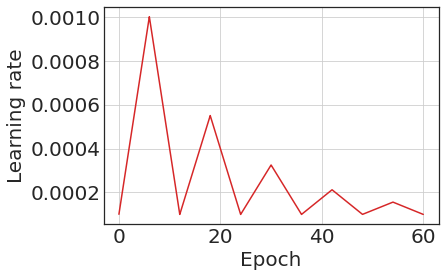

In [21]:
batches = np.linspace(0,len(metrics['lrs']),len(metrics['lrs'])+1)
epoch_list = batches/iterations_per_epoch

plt.plot(epoch_list[1:],metrics['lrs'], 'C3-')
plt.grid()
plt.ylabel("Learning rate")
plt.xlabel("Epoch")

Text(0.5, 45.5, 'Epochs')

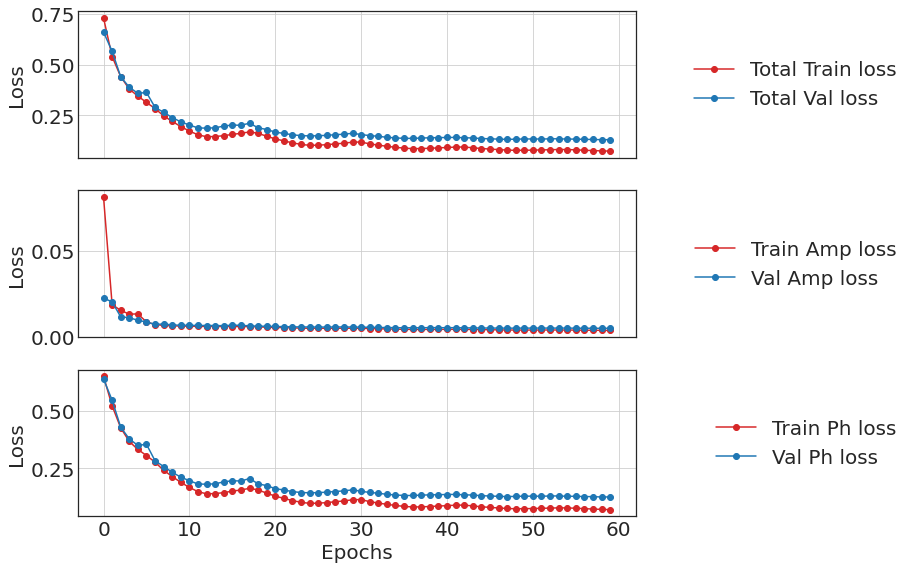

In [34]:
losses_arr = np.array(metrics['losses'])
val_losses_arr = np.array(metrics['val_losses'])
losses_arr.shape
fig, ax = plt.subplots(3,sharex=True, figsize=(15, 8))
ax[0].plot(losses_arr[:,0], 'C3o-', label = "Total Train loss")
ax[0].plot(val_losses_arr[:,0], 'C0o-', label = "Total Val loss")
ax[0].set(ylabel='Loss')
ax[0].grid()
ax[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax[1].plot(losses_arr[:,1], 'C3o-', label = "Train Amp loss")
ax[1].plot(val_losses_arr[:,1], 'C0o-', label = "Val Amp loss")
ax[1].set(ylabel='Loss')
ax[1].grid()
ax[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax[2].plot(losses_arr[:,2], 'C3o-', label = "Train Ph loss")
ax[2].plot(val_losses_arr[:,2], 'C0o-', label = "Val Ph loss")
ax[2].set(ylabel='Loss')
ax[2].grid()
ax[2].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

plt.tight_layout()
plt.xlabel("Epochs")

In [23]:
model.eval() #imp when have dropout etc
amps = []
phs = []
for i, ft_images in enumerate(testloader):
    ft_images = ft_images[0].to(device)
    amp, ph = model(ft_images)
    for j in range(ft_images.shape[0]):
        amps.append(amp[j].detach().to("cpu").numpy())
        phs.append(ph[j].detach().to("cpu").numpy())

/home/mcheruka/PyTorch/lib/python3.8/site-packages/torch/nn/functional.py:3590: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [24]:
amps = np.array(amps).squeeze()
phs = np.array(phs).squeeze()
print(amps.shape, amps.dtype)
print(phs.shape, phs.dtype)

(3600, 64, 64) float32
(3600, 64, 64) float32


<Figure size 432x288 with 0 Axes>

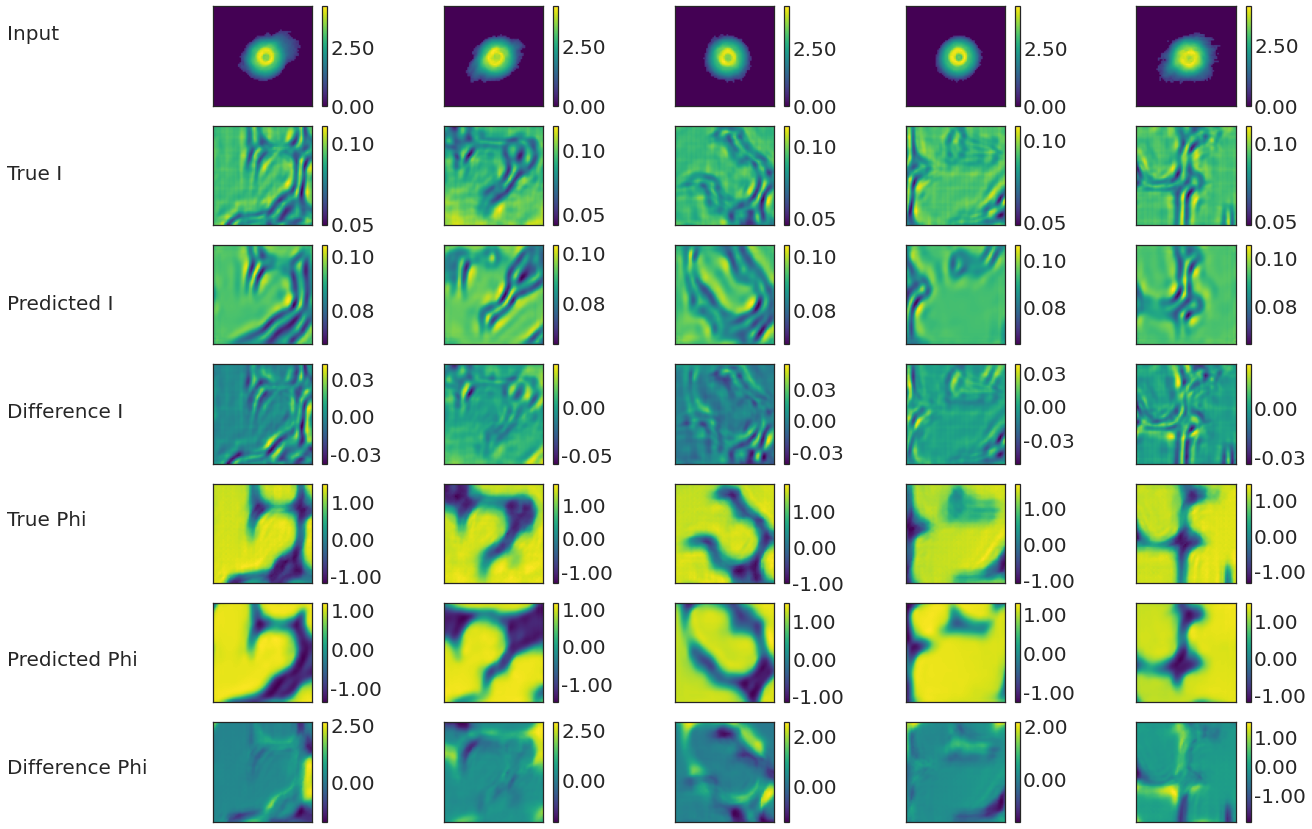

In [25]:
h,w = 64,64
ntest=amps.shape[0]
plt.viridis()
n = 5
f,ax=plt.subplots(7,n,figsize=(20, 15))
plt.gcf().text(0.02, 0.85, "Input", fontsize=20)
plt.gcf().text(0.02, 0.72, "True I", fontsize=20)
plt.gcf().text(0.02, 0.6, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.5, "Difference I", fontsize=20)
plt.gcf().text(0.02, 0.4, "True Phi", fontsize=20)
plt.gcf().text(0.02, 0.27, "Predicted Phi", fontsize=20)
plt.gcf().text(0.02, 0.17, "Difference Phi", fontsize=20)

for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

        # display FT
    im=ax[0,i].imshow(np.log10(X_test[j].reshape(h, w)+1))
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)

    # display original intens
    im=ax[1,i].imshow(Y_I_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted intens
    im=ax[2,i].imshow(amps[j].reshape(h, w))
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)
    
        # display original phase
    im=ax[4,i].imshow(Y_phi_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[4,i], format='%.2f')
    ax[4,i].get_xaxis().set_visible(False)
    ax[4,i].get_yaxis().set_visible(False)
    
    # display predicted phase
    im=ax[5,i].imshow(phs[j].reshape(h, w))
    plt.colorbar(im, ax=ax[5,i], format='%.2f')
    ax[5,i].get_xaxis().set_visible(False)
    ax[5,i].get_yaxis().set_visible(False)
    
    #Difference in amplitude
    im=ax[3,i].imshow(Y_I_test[j].reshape(h, w)-amps[j].reshape(h, w))
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
    
    # Difference in phase
    im=ax[6,i].imshow(Y_phi_test[j].reshape(h, w)-phs[j].reshape(h, w))
    plt.colorbar(im, ax=ax[6,i], format='%.2f')
    ax[6,i].get_xaxis().set_visible(False)
    ax[6,i].get_yaxis().set_visible(False)
    
plt.show()

In [26]:
point_size = 3
overlap = 4*point_size

In [27]:
tst_side = 60

composite_amp = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_amp)
data_reshaped = amps.reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_amp[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1

In [28]:

composite_phase = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_phase)
data_reshaped = phs.reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_phase[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1

In [29]:
stitched_phase = composite_phase[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp = composite_amp[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp_down = resize(stitched_amp, (60,60), preserve_range=True, anti_aliasing=True)
stitched_phase_down = resize(stitched_phase, (60,60), preserve_range=True, anti_aliasing=True)

In [30]:
true_amp = Y_I_test.reshape(NLTEST,NLTEST,64,64)
true_ph = Y_phi_test.reshape(NLTEST,NLTEST,64,64)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


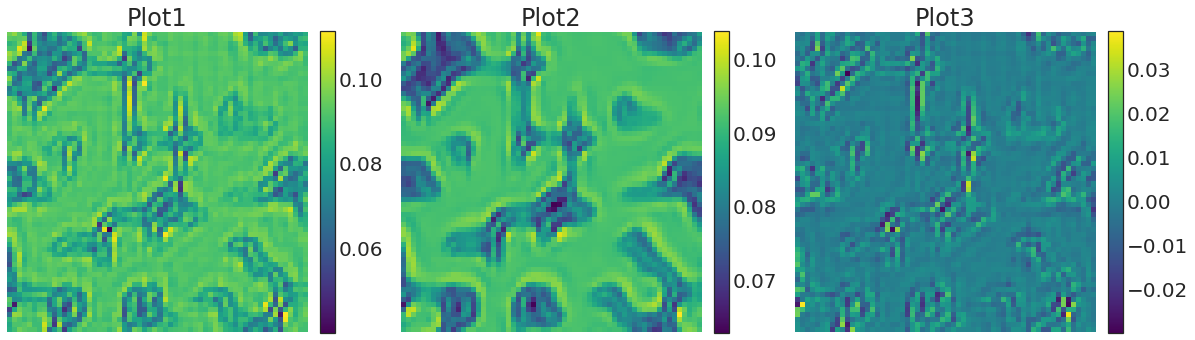

In [31]:
plot3([true_amp[:,:,32,32],stitched_amp_down,stitched_amp_down-true_amp[:,:,32,32]],[])

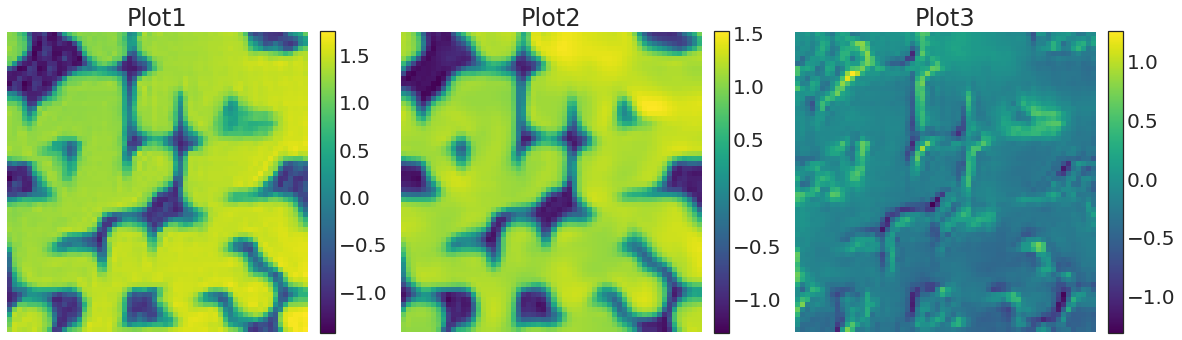

In [32]:
plot3([true_ph[:,:,32,32],stitched_phase_down,stitched_phase_down-true_ph[:,:,32,32]],[])

In [33]:
from sklearn.metrics import mean_squared_error as mse
print ("MSE in amplitude: ", mse(stitched_amp_down, true_amp[:,:,32,32]))
print ("MSE in phase: ", mse(stitched_phase_down, true_ph[:,:,32,32]))

MSE in amplitude:  4.183426184426945e-05
MSE in phase:  0.0879146252555323
